In [1]:
from IPython.display import HTML, display

def hide_code():
    display(HTML('''
        <script>
            code_show=true; 
            function code_toggle() {
                if (code_show){
                    $('div.input').hide();
                } else {
                    $('div.input').show();
                }
                code_show = !code_show
            } 
            $( document ).ready(code_toggle);
        </script>
        <form><input type="button" value="Click here to toggle on/off the code." onclick="code_toggle()"></form>
    '''))

hide_code()


In [2]:
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from spotipy.oauth2 import SpotifyOAuth
import spotipy
from spotipy.oauth2 import SpotifyOAuth


load_dotenv()


spotify_palette = [
    "#1DB954",  # Spotify Green
    "#B3B3B3",  # Light Green
    "#191414",  # Almost Black
    "#535353",  # Dark Gray
    "#1ED760",  # Light Gray
    "#0D72FF",  # Spotify Blue Accent
    "#FF5A5F",  # Pinkish Accent
    "#FFD700",  # Yellow Highlight
    "#FF8C42",  # Orange Accent
    "#9B51E0"   # Purple Accent
]

In [3]:
scope = "user-top-read user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=os.getenv("SPOTIPY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIPY_CLIENT_SECRET"),
    redirect_uri=os.getenv("SPOTIPY_REDIRECT_URI"),
    scope=scope
))


**Verify that we are pulling data for the correct user.**

In [4]:

user = sp.current_user()
user["display_name"]

'Descj001'

**Bar chart to determine if theres a pattern between genres you listen to and not decide or to save. Shows user if there are underlying trends to music that they want to keep in the future, and songs they may just listen to in that given moment for whatever reason.**


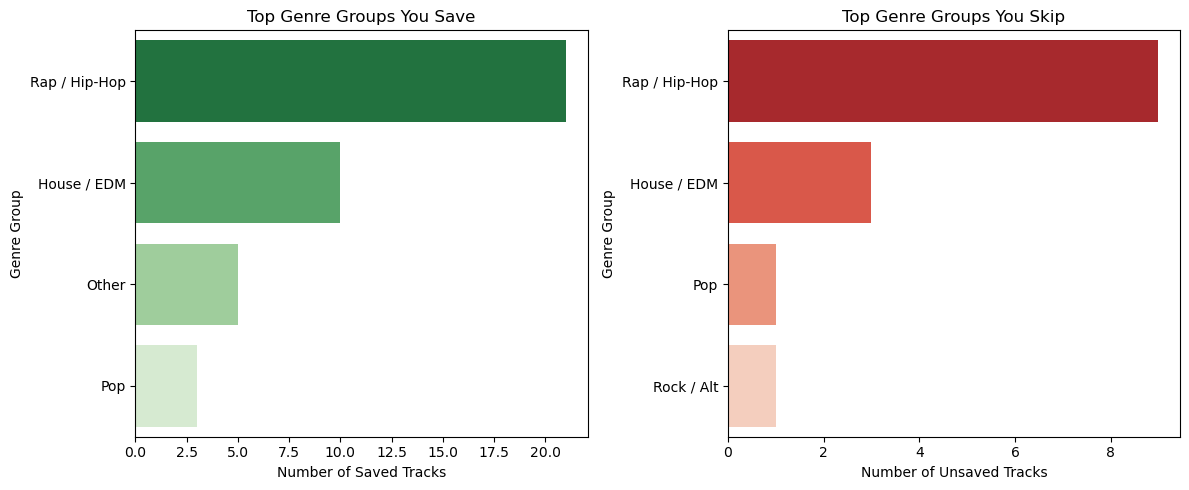

In [5]:
top_tracks = sp.current_user_top_tracks(limit=50, time_range="medium_term")
track_ids = [track['id'] for track in top_tracks['items']]
saved_status = sp.current_user_saved_tracks_contains(track_ids)

track_data = []
for track, saved in zip(top_tracks['items'], saved_status):
    artist_id = track['artists'][0]['id']
    artist_info = sp.artist(artist_id)
    genres = artist_info['genres']

    track_data.append({
        "track": track['name'],
        "artist": track['artists'][0]['name'],
        "genres": genres,
        "saved": saved
    })

df = pd.DataFrame(track_data)


saved_genres = [genre for genres, saved in zip(df['genres'], df['saved']) if saved for genre in genres]
unsaved_genres = [genre for genres, saved in zip(df['genres'], df['saved']) if not saved for genre in genres]

df_saved = pd.DataFrame(Counter(saved_genres).most_common(50), columns=['Genre', 'Saved Count'])
df_unsaved = pd.DataFrame(Counter(unsaved_genres).most_common(50), columns=['Genre', 'Unsaved Count'])


def map_genre(genre):
    genre_lower = genre.lower()
    if "rap" in genre_lower or "hip hop" in genre_lower or "drill" in genre_lower:
        return "Rap / Hip-Hop"
    elif "house" in genre_lower or "edm" in genre_lower or "electro" in genre_lower:
        return "House / EDM"
    elif "pop" in genre_lower:
        return "Pop"
    elif "grunge" in genre_lower or "rock" in genre_lower or "punk" in genre_lower or "britpop" in genre_lower or "madchester" in genre_lower:
        return "Rock / Alt"
    else:
        return "Other"

df_saved["Genre Group"] = df_saved["Genre"].apply(map_genre)
df_unsaved["Genre Group"] = df_unsaved["Genre"].apply(map_genre)


df_saved_grouped = df_saved.groupby("Genre Group")["Saved Count"].sum().reset_index()
df_unsaved_grouped = df_unsaved.groupby("Genre Group")["Unsaved Count"].sum().reset_index()

df_saved_grouped = df_saved_grouped.sort_values("Saved Count", ascending=False)
df_unsaved_grouped = df_unsaved_grouped.sort_values("Unsaved Count", ascending=False)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=df_saved_grouped, x="Saved Count", y="Genre Group", palette="Greens_r")
plt.title("Top Genre Groups You Save")
plt.xlabel("Number of Saved Tracks")
plt.ylabel("Genre Group")

plt.subplot(1, 2, 2)
sns.barplot(data=df_unsaved_grouped, x="Unsaved Count", y="Genre Group", palette="Reds_r")
plt.title("Top Genre Groups You Skip")
plt.xlabel("Number of Unsaved Tracks")
plt.ylabel("Genre Group")

plt.tight_layout()
plt.savefig("top_genre_groups.png", dpi=300, bbox_inches="tight")
plt.show()


**Scatter plot showing artists you listen to with following on x axis and popularity, how many people are currenlty listening to them. Showing if the user listens to "underground" artists, or if any artists they listen to have "fallen off", as in they used to be big but not any more**


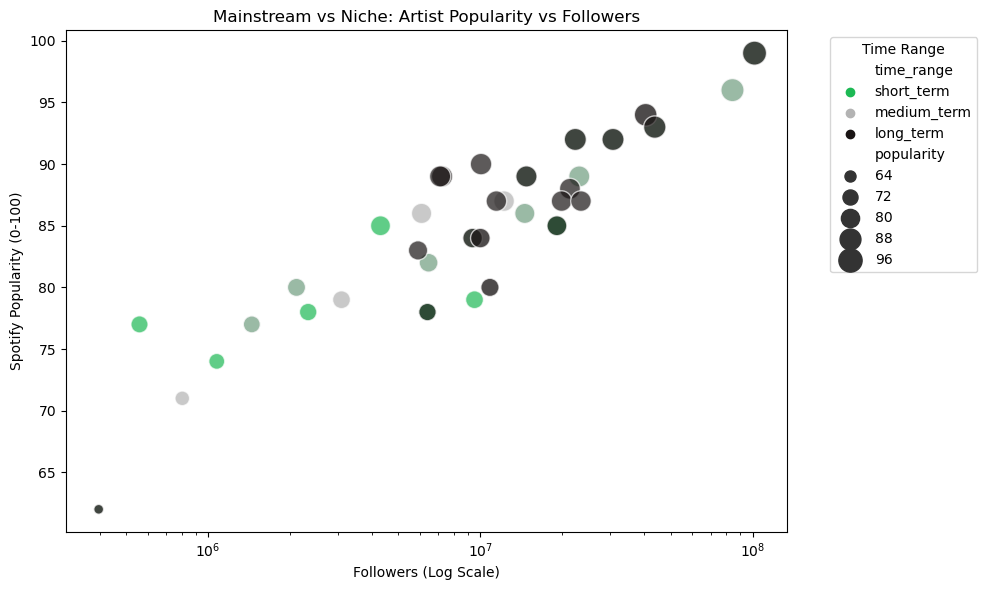

In [6]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=os.getenv("SPOTIPY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIPY_CLIENT_SECRET"),
    redirect_uri=os.getenv("SPOTIPY_REDIRECT_URI"),
    scope="user-top-read"
))


time_ranges = ["short_term", "medium_term", "long_term"]
artist_data, track_data, genre_list = [], [], []

for tr in time_ranges:
    top_artists = sp.current_user_top_artists(limit=20, time_range=tr)
    for artist in top_artists['items']:
        artist_data.append({
            "time_range": tr,
            "artist": artist["name"],
            "followers": artist["followers"]["total"],
            "popularity": artist["popularity"],
            "genres": artist["genres"]
        })
        genre_list.extend(artist["genres"])
    
    top_tracks = sp.current_user_top_tracks(limit=20, time_range=tr)
    for track in top_tracks["items"]:
        track_data.append({
            "time_range": tr,
            "track": track["name"],
            "artist": track["artists"][0]["name"],
            "popularity": track["popularity"]
        })

df_artists = pd.DataFrame(artist_data)
df_tracks = pd.DataFrame(track_data)


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_artists, x="followers", y="popularity", hue="time_range",
                palette={"short_term":"#1DB954", "medium_term":"#B3B3B3", "long_term":"#191414"},
                size="popularity", sizes=(50, 300), alpha=0.7)

plt.xscale("log")  # log scale to handle huge differences in followers
plt.title("Mainstream vs Niche: Artist Popularity vs Followers")
plt.xlabel("Followers (Log Scale)")
plt.ylabel("Spotify Popularity (0-100)")
plt.legend(title="Time Range", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("artist_popularity_vs_followers.png", dpi=300)
plt.show()




**Shows user how their listening may have changed over time, short term being past ~4 weeks, medium past ~6 months, and long term being the past several years. The scatter plot visualizes how top genres shift in prominence across these periods, helping the user see evolving preferences, emerging trends, and lasting favorites.**

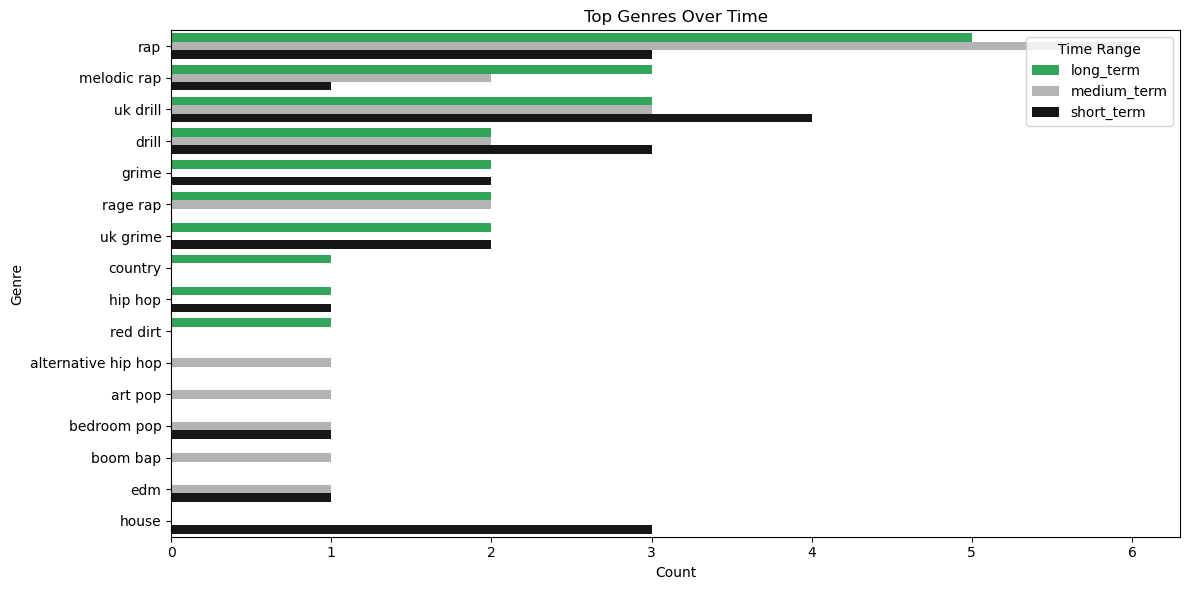

In [7]:
import os
import pandas as pd
import plotly.graph_objects as go
from spotipy.oauth2 import SpotifyOAuth
import spotipy


sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=os.getenv("SPOTIPY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIPY_CLIENT_SECRET"),
    redirect_uri=os.getenv("SPOTIPY_REDIRECT_URI"),
    scope="user-top-read"
))


time_ranges = ["short_term", "medium_term", "long_term"]

artist_data, track_data, genre_data = [], [], []

for tr in time_ranges:
    # Top artists
    top_artists = sp.current_user_top_artists(limit=20, time_range=tr)
    for artist in top_artists["items"]:
        artist_data.append({
            "time_range": tr,
            "artist": artist["name"],
            "genres": artist["genres"]
        })
        genre_data.extend([(g, tr) for g in artist["genres"]])

    # Top tracks
    top_tracks = sp.current_user_top_tracks(limit=20, time_range=tr)
    for track in top_tracks["items"]:
        track_data.append({
            "time_range": tr,
            "track": track["name"],
            "artist": track["artists"][0]["name"]
        })

df_artists = pd.DataFrame(artist_data)
df_tracks = pd.DataFrame(track_data)
df_genres = pd.DataFrame(genre_data, columns=["genre", "time_range"])

def compare_sets(long, medium, short, label):
    long_set, med_set, short_set = set(long), set(medium), set(short)
    return {
        "still_listen": sorted(long_set & med_set & short_set),
        "new_obsessions": sorted(short_set - med_set - long_set),
        "faded_favorites": sorted(long_set - med_set - short_set),
        "medium_only": sorted(med_set - long_set - short_set)
    }

artist_compare = compare_sets(
    df_artists[df_artists.time_range=="long_term"]["artist"],
    df_artists[df_artists.time_range=="medium_term"]["artist"],
    df_artists[df_artists.time_range=="short_term"]["artist"],
    "Artists"
)

track_compare = compare_sets(
    df_tracks[df_tracks.time_range=="long_term"]["track"],
    df_tracks[df_tracks.time_range=="medium_term"]["track"],
    df_tracks[df_tracks.time_range=="short_term"]["track"],
    "Tracks"
)

genre_compare = compare_sets(
    df_genres[df_genres.time_range=="long_term"]["genre"],
    df_genres[df_genres.time_range=="medium_term"]["genre"],
    df_genres[df_genres.time_range=="short_term"]["genre"],
    "Genres"
)


genre_counts = df_genres.groupby(["time_range", "genre"]).size().reset_index(name="count")
top_genres = genre_counts.groupby("time_range").apply(lambda x: x.nlargest(10, "count")).reset_index(drop=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres, x="count", y="genre", hue="time_range", palette=spotify_palette)
plt.title("Top Genres Over Time")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.legend(title="Time Range")
plt.tight_layout()
plt.show()


**Shows how the user’s top artists rank across different time ranges, short term (~4 weeks), medium term (~6 months), and long term (several years). The heatmap highlights each artist’s position within the rankings, making it easy to spot consistent favorites, rising stars, and artists that have faded over time.**

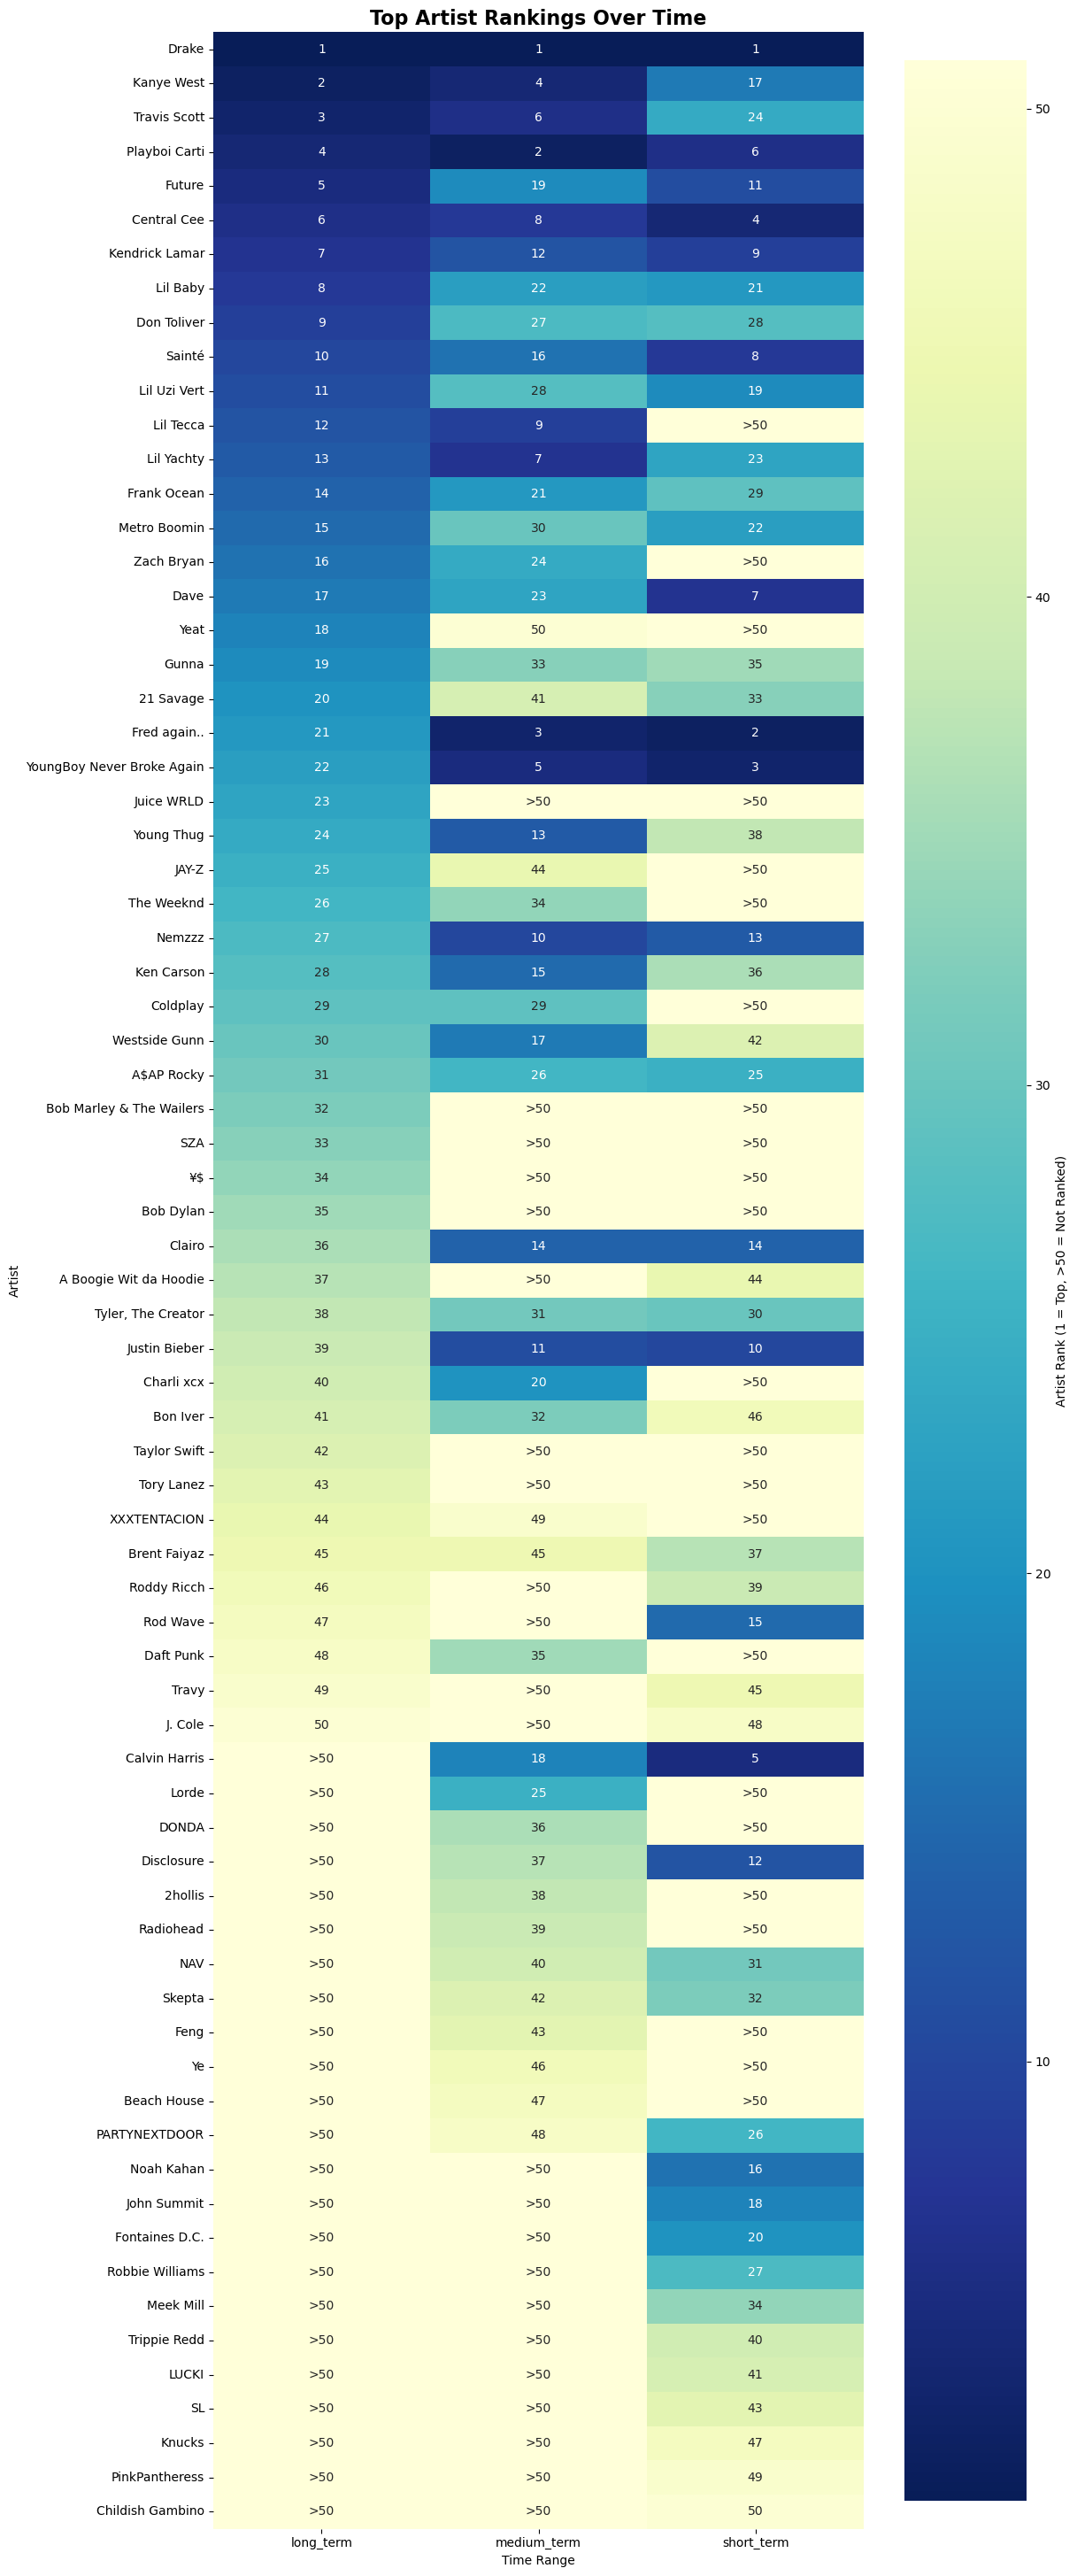

In [12]:

time_ranges = ["long_term", "medium_term", "short_term"]
artist_rank_data = []

for tr in time_ranges:
    top_artists = sp.current_user_top_artists(limit=50, time_range=tr)
    for rank, artist in enumerate(top_artists["items"], start=1):
        artist_rank_data.append({
            "time_range": tr,
            "artist": artist["name"],
            "rank": rank
        })

df_artists = pd.DataFrame(artist_rank_data)


heatmap_df = (
    df_artists.pivot(index="artist", columns="time_range", values="rank")
    .reindex(columns=time_ranges)
)

not_ranked_mask = heatmap_df.isna()

heatmap_df = heatmap_df.fillna(51).astype(int)

heatmap_df = heatmap_df.sort_values(
    by=["long_term", "medium_term", "short_term"],
    ascending=True,
    kind="mergesort"
)

annot_df = heatmap_df.astype(str)
annot_df[not_ranked_mask.loc[heatmap_df.index]] = ">50"

plt.figure(figsize=(12, max(6, len(heatmap_df) * 0.4)))
sns.heatmap(
    heatmap_df,
    annot=annot_df,
    fmt="",
    cmap="YlGnBu_r",
    cbar_kws={"label": "Artist Rank (1 = Top, >50 = Not Ranked)"}
)
plt.title("Top Artist Rankings Over Time", fontsize=16, weight="bold")
plt.xlabel("Time Range")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()



**Visualizes how the user’s top genres rise and fall in ranking across different time ranges — short term (~4 weeks), medium term (~6 months), and long term (several years). The bump chart highlights which genres have stayed consistently popular, which have gained traction recently, and which have declined over time, providing an intuitive view of how the user’s music taste has evolved**

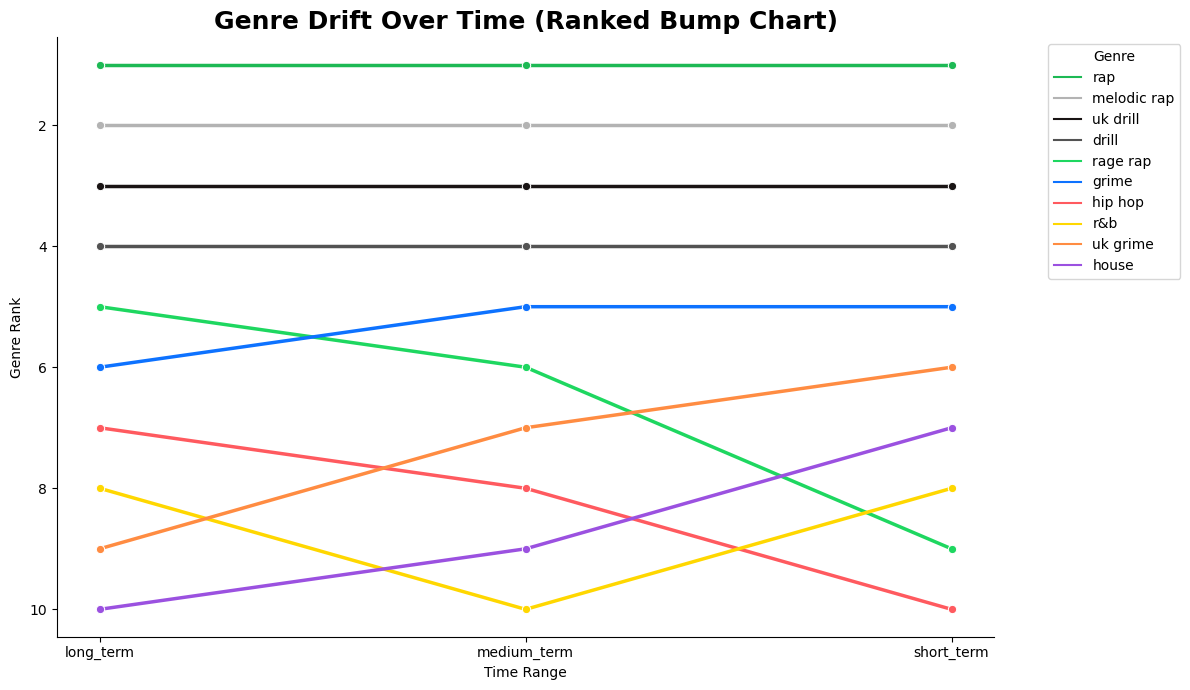

In [10]:

time_ranges = ["long_term", "medium_term", "short_term"]
genre_data = []

for tr in time_ranges:
    results = sp.current_user_top_artists(limit=50, time_range=tr)
    for artist in results["items"]:
        for genre in artist["genres"]:
            genre_data.append({"genre": genre, "time_range": tr})

df_genres = pd.DataFrame(genre_data)

df_genres_count = (
    df_genres.groupby(["time_range", "genre"])
    .size()
    .reset_index(name="count")
)

top_genres = (
    df_genres_count.groupby("genre")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

df_top_genres = df_genres_count[df_genres_count["genre"].isin(top_genres)]

df_ranked = (
    df_top_genres.groupby("time_range")
    .apply(lambda x: x.sort_values("count", ascending=False)
           .assign(rank=lambda df: range(1, len(df) + 1)))
    .reset_index(drop=True)
)

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_ranked,
    x="time_range",
    y="rank",
    hue="genre",
    marker="o",
    palette=spotify_palette,
    linewidth=2.5
)

plt.gca().invert_yaxis()

plt.title("Genre Drift Over Time (Ranked Bump Chart)", fontsize=18, weight="bold")
plt.xlabel("Time Range")
plt.ylabel("Genre Rank")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()
plt.tight_layout()
plt.show()

